# Prototyping 
using rolling avg. over the single frames to predict a video's content

---

### Pipeline evaluation

using PyTorch's `DataLoader` and `Dataset` to facilitate data loading and preprocessing.


In [1]:
# as the data stuff lies in another subdirectory 
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import os 

from torch.utils.data import DataLoader 
from torchvision import transforms
from data.dataset import SportsDataset
from data.transformations import Rescale, RandomCrop, ToTensor

In [2]:
# set data root 
root_data = "/home/maternus/Coding/rolling_avg_pytorch/data/sports_data"

In [3]:
transformations = transforms.Compose([
    Rescale(256), RandomCrop(224), ToTensor()])
dataset = SportsDataset(root_dir=root_data, 
                        samples_name=os.path.join(root_data, "cleaned.csv"), 
                        transform=transformations)
print(f"dataset length: {dataset.__len__()}")

dataset length: 10018


In [4]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, 
                        num_workers=0)

for sample in dataloader:
    print(sample["label"])
    break

tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0.]], dtype=torch.float64)


batch size: 	 4
batch shape: 	 torch.Size([4, 3, 224, 224])


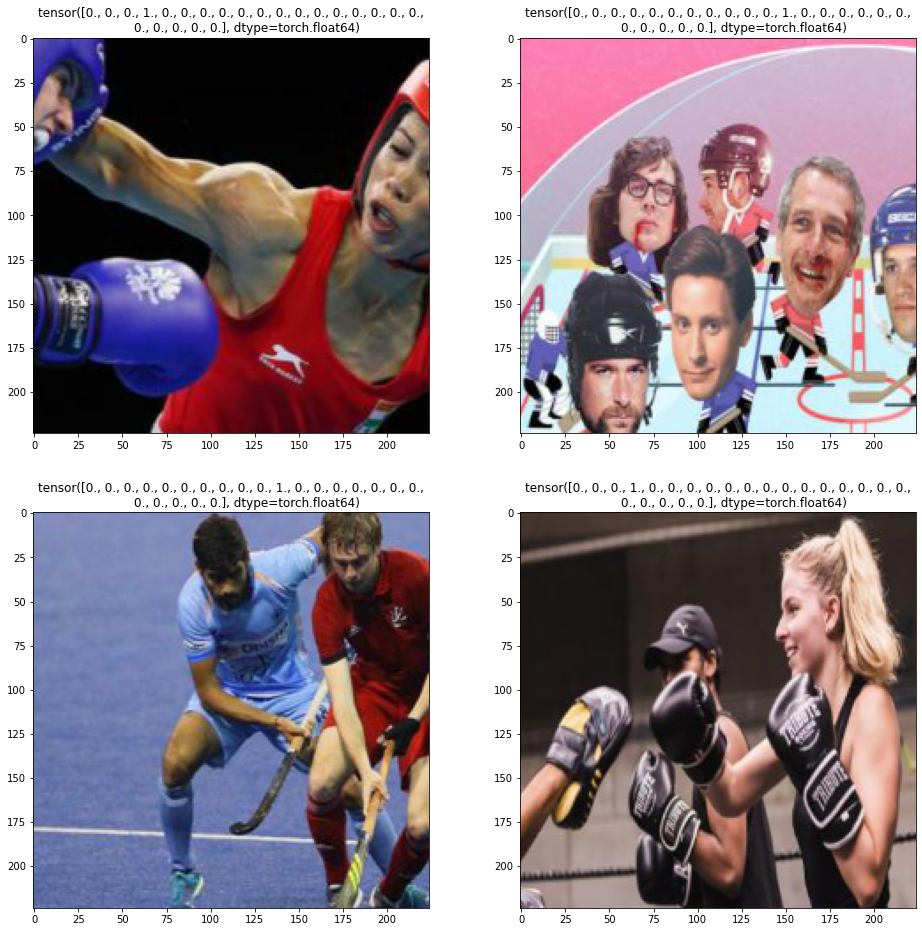

In [5]:
# inspect final data loader output 
for index, i in enumerate(dataloader):
    print(f"batch size: \t {i['label'].__len__()}")
    print(f"batch shape: \t {i['image'].shape}")
    
    plt.figure(figsize=(16,16))
    for idx in range(4):
        plt.subplot(2,2,idx+1)
        plt.title(i["label"][idx])
        plt.imshow(np.transpose(i["image"][idx], (1,2,0)))
    break

### Model evaluation

using a pretrained model (possibly a ResNet18) and adapt to sports dataset.

In [6]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
from torchvision import models
from model.model import SportsModel

##### Fine tuning a model

i.e. using a pretrained model but updating all weigths during training 

...takes quite long

In [7]:
# TODO ...

##### Feature extraction

i.e. using a pretrained model but keeping the feature extraction layers fixed

In [8]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, 
                        num_workers=4)

trainer = pl.Trainer(max_epochs=1)
sports_model = SportsModel()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [9]:
trainer.fit(sports_model, dataloader)

/home/maternus/anaconda3/envs/rolling-avg-video/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11 M  


/home/maternus/anaconda3/envs/rolling-avg-video/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [10]:
# save the final model
torch.save(sports_model.model.state_dict(), 
           "../model/model_output/model_20102020_1E2.pth")

##### Model evaluation

comparing inference performance 

 - based on the plots, the performance looks ok

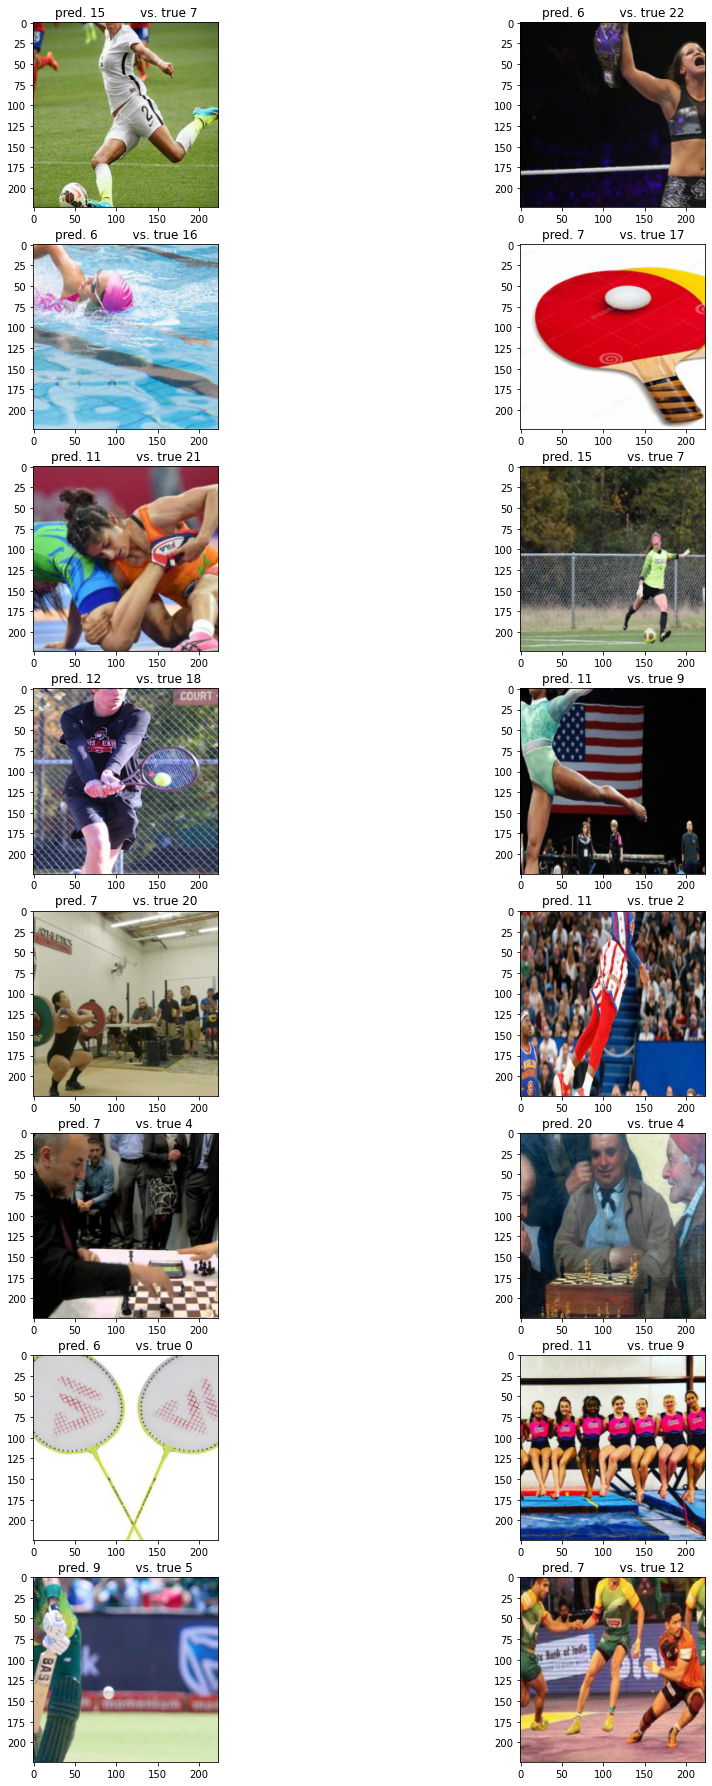

In [11]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, 
                        num_workers=4)

for sample in dataloader:
    x, y = sample["image"], sample["label"]
    y_hat = sports_model.model(x)
        
    plt.figure(figsize=(16,32))
    for i in range(16):
        plt.subplot(8,2,i+1)
        plt.title(f"pred. {y_hat.max(axis=1).indices[i].numpy()} \
        vs. true {np.argmax(y, axis=1)[i]}")
        plt.imshow(np.transpose(x[i], (1,2,0)))
    break